In [1]:
import os                        # for os.path.exists
import json                      # for loading metadata
import urllib                    # for downloading remote files 
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn
import sklearn.tree
import sklearn.metrics
import sklearn.ensemble
import sklearn.preprocessing

# Matplotlib might complain that a lot of figures are open, but suppress that warning.
plt.rcParams.update({'figure.max_open_warning': 0})

**Run the code cell below** to define some utility functions for fetching data and for processing images.

In [2]:
def download(remoteurl: str, localfile: str):
    """
    Download remoteurl to localfile, unless localfile already exists.
    Returns the localfile string.
    """
    if not os.path.exists(localfile):
        print("Downloading %s..." % localfile)
        filename, headers = urllib.request.urlretrieve(remoteurl, localfile)
    return localfile

def rgba_to_rgb(image):
    """
    Converts image from RGBA format (H,W,4) to RGB format (H,W,3).
    Returns the new RGB image.
    """
    assert image.ndim == 3, "Expected 3-dimensional array"
    assert image.shape[2] == 4, "Expected 4 colour channels"
    rgb, a = np.split(image, [3], axis=2)  # Split into (H,W,3) and (H,W,1)
    return a*rgb + (1-a)                   # Apply alpha blending to get RGB

<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>
<div style="border-bottom: 3px solid black"></div>

# Q1 &mdash; Download emoji metadata and images [20 marks total]

The image data and corresponding metadata that you need for this assignment is available from [github.com/imcal/emoji-data](https://github.com/iamcal/emoji-data), where you can also find a description of the data. The specific files you'll need are only:
* *emoji.json*
* *sheets-clean/sheet_{vendor}_{size}_clean.png*

where *{vendor}* is one of *{apple, facebook, google, twitter}* and *{size}* is the pixel resolution. You'll need emojis from all four vendors, but only the small *16x16* pixel versions (to make training faster). However, do NOT download the files manually.

<div style="border-bottom: 1px solid black;"></div>

### *Q1a &mdash;  Write code to download the files [5 marks]*

Use the *download* function defined above to fetch the five files *procedurally*. 

*Hint:* When you visit a Github URL in your browser, Github normally returns an HTML file for rendering in your web browser. To ask Github for an actual raw file (instead of the web page for displaying that file) you must use special URLs. If you view a file in your web browser https://github.com/iamcal/emoji-data/{path_to_file} then you should use URL https://github.com/iamcal/emoji-data/raw/master/{path_to_file}.

In [3]:
# Your code here. Use as many lines as you need.
# Feel free to define global variables like EMOJI_SIZE=16 for later use.
download('https://github.com/iamcal/emoji-data/raw/master/emoji.json','emoji.json')
download('https://github.com/iamcal/emoji-data/raw/master/sheets-clean/sheet_apple_16_clean.png','sheet_apple_16_clean.png')
download('https://github.com/iamcal/emoji-data/raw/master/sheets-clean/sheet_facebook_16_clean.png','sheet_facebook_16_clean.png')
download('https://github.com/iamcal/emoji-data/raw/master/sheets-clean/sheet_google_16_clean.png','sheet_google_16_clean.png')
download('https://github.com/iamcal/emoji-data/raw/master/sheets-clean/sheet_twitter_16_clean.png','sheet_twitter_16_clean.png');

In [4]:
global EMOJI_SIZE
EMOJI_SIZE = 16
global PAD
PAD = 1

<div style="border-bottom: 1px solid black;"></div>

### *Q1b &mdash;  Load and inspect the emoji metadata [5 marks]*

The emoji metadata is contained in a JSON file, which Python's **[json](https://docs.python.org/3/library/json.html)** module can easily load and parse for you.

**Write code** to load the *emoji.json* file, then display the metadata for the first emoji (index 0) so that you can see an example. It should have short name '*hash*'.

In [5]:
# Your answer here. Aim for 2-4 lines.
# Keep the metadata in a global variable that you can keep referring to.
with open("emoji.json") as emoji:
    metadata = json.load(emoji)
    
print(metadata[0])

{'name': 'HASH KEY', 'unified': '0023-FE0F-20E3', 'non_qualified': '0023-20E3', 'docomo': 'E6E0', 'au': 'EB84', 'softbank': 'E210', 'google': 'FE82C', 'image': '0023-fe0f-20e3.png', 'sheet_x': 0, 'sheet_y': 0, 'short_name': 'hash', 'short_names': ['hash'], 'text': None, 'texts': None, 'category': 'Symbols', 'sort_order': 135, 'added_in': '0.6', 'has_img_apple': True, 'has_img_google': True, 'has_img_twitter': True, 'has_img_facebook': False}


**Write code** to find the index of the emoji having short name *'laughing'*, then display its metadata (the *dict* object). Do not use the *sort_order* field of the emoji metadata, it is not relevant to this assignment.

In [6]:
# Your answer here. Aim for 1-5 lines. Keep the index in a global variable for later.
for i, obj in enumerate(metadata):
    if obj['short_name'] == 'laughing':
        print(obj) 
        index = i
        print(index)

{'name': 'SMILING FACE WITH OPEN MOUTH AND TIGHTLY-CLOSED EYES', 'unified': '1F606', 'non_qualified': None, 'docomo': 'E72A', 'au': 'EAC5', 'softbank': None, 'google': 'FE332', 'image': '1f606.png', 'sheet_x': 30, 'sheet_y': 38, 'short_name': 'laughing', 'short_names': ['laughing', 'satisfied'], 'text': None, 'texts': [':>', ':->'], 'category': 'Smileys & Emotion', 'sort_order': 5, 'added_in': '0.6', 'has_img_apple': True, 'has_img_google': True, 'has_img_twitter': True, 'has_img_facebook': True}
1068


<div style="border-bottom: 1px solid black;"></div>

### *Q1c &mdash;  Load and inspect the emoji image data [10 marks]*

The emoji image data is contained in PNG files, which Matplotlib's **[imread](https://matplotlib.org/3.3.2/api/_as_gen/matplotlib.pyplot.imread.html)** function can load as a Numpy array. The image format is RGBA (*red*, *green*, *blue*, *alpha*) where *alpha* determines the opacity of each pixel.

**Write code** to load the four emoji sheet images. The list of images should be in order *{apple,facebook,google,twitter}*.

In [7]:
# Your answer here. Aim for 1-4 lines. You can define a global variable to hold the list of numpy arrays.
sheets = {"apple" : plt.imread('sheet_apple_16_clean.png'), "facebook" : plt.imread('sheet_facebook_16_clean.png'), 
          "google" : plt.imread('sheet_google_16_clean.png'),"twitter" : plt.imread('sheet_twitter_16_clean.png')}

**Write code** to plot each vendor's sheet image. Generate four separate plots, where the title of each plot should be "*vendor* (*height*, *width*, *channels*)" where *height* and *width* are the size of the sheet and *channels* is the number of colour channels. Use the *figsize* argument of Matplotlib's *figure* function to enlarge the figures. The top of your first plot should look like this:

<img src="img/example-apple-emoji-sheet.png" width=650/>


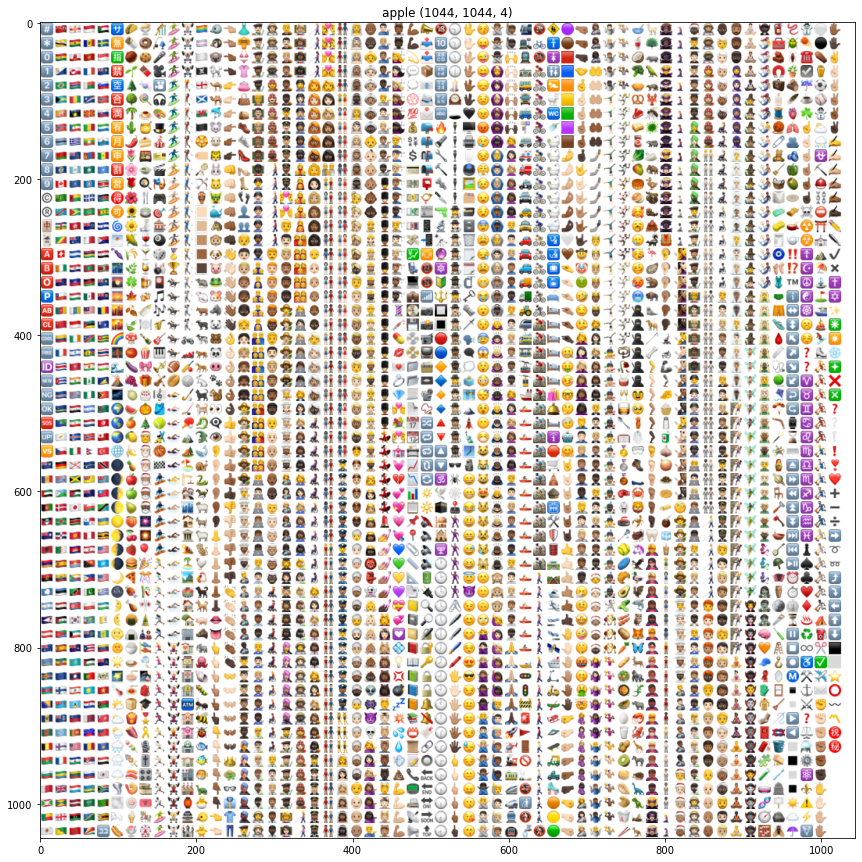

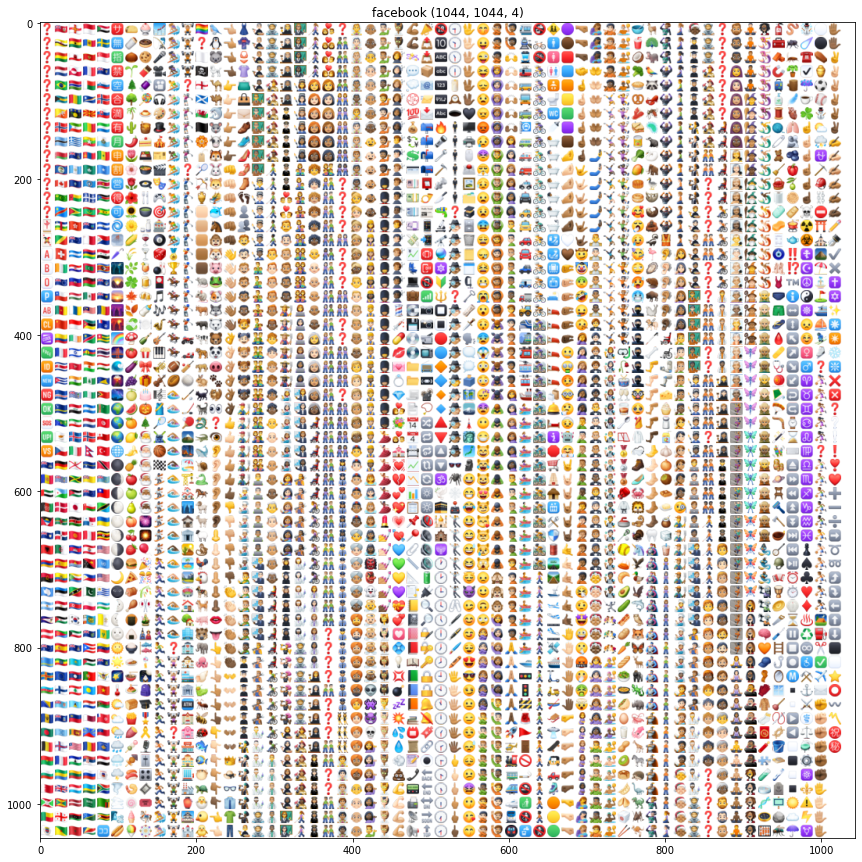

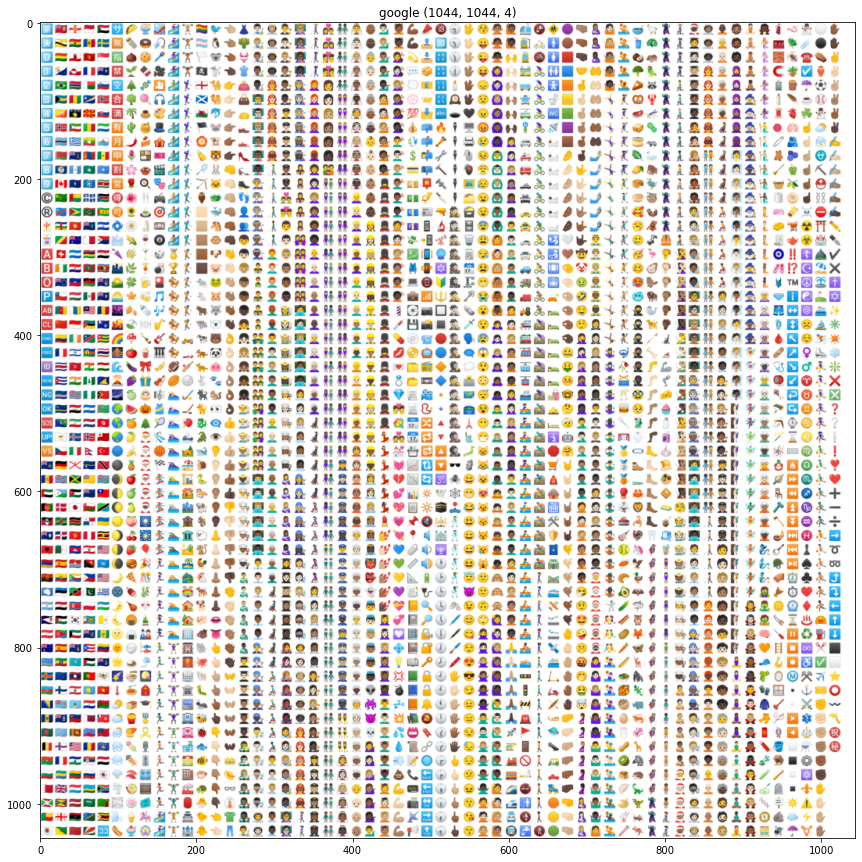

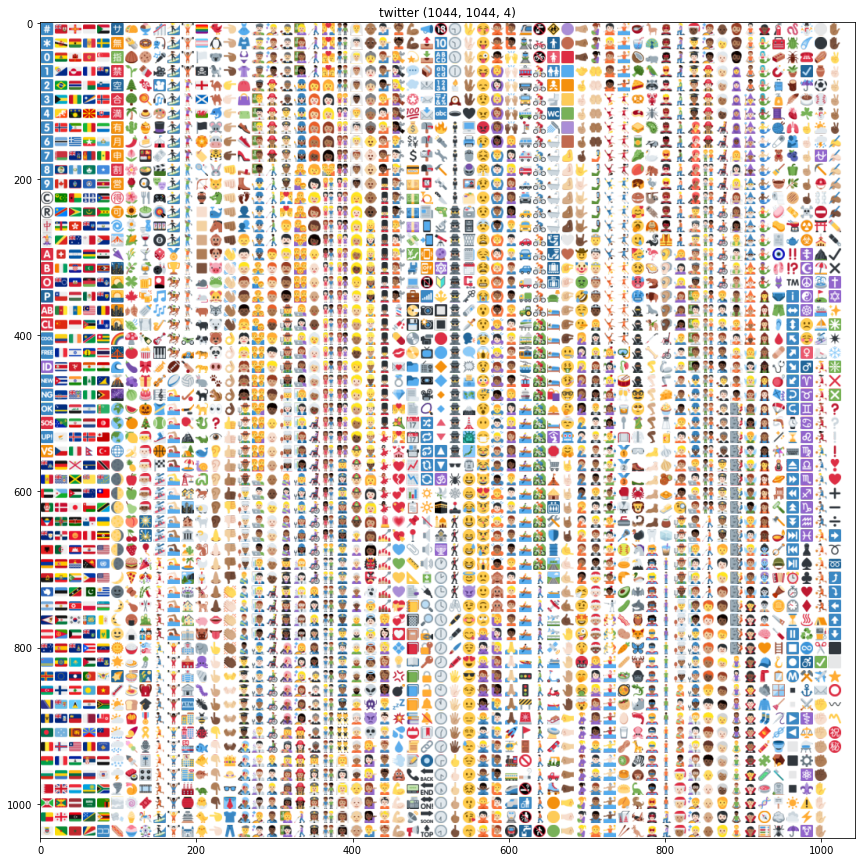

In [8]:
# Your answer here. Aim for 4-6 lines.
for vendor, sheet in sheets.items():
    plt.figure(figsize=(15,15))
    plt.imshow(sheet)
    plt.title(f'{vendor} {sheet.shape}')

**Write code** to generate the same four plots as above, except use Numpy slicing to display only the first 3 rows and 8 columns of the sheet. To ensure you do not crop any emojis, take note of any "padding" between the 16x16 emojis in the sheet. Your first plot should look like this, but with the shape numbers (?) and axis ticks filled in:

<img src="img/example-apple-emoji-sheet-slice.png" width=650/>

(If you see a red question mark like <span style="color:red">?</span> for a vendor, it means they do not provide that particular emoji.)

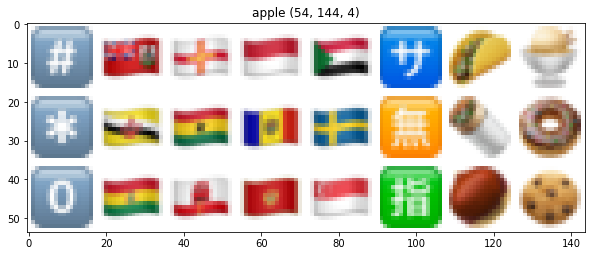

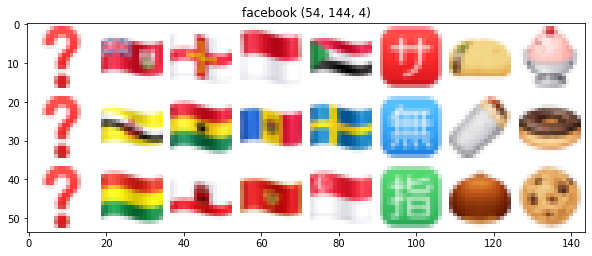

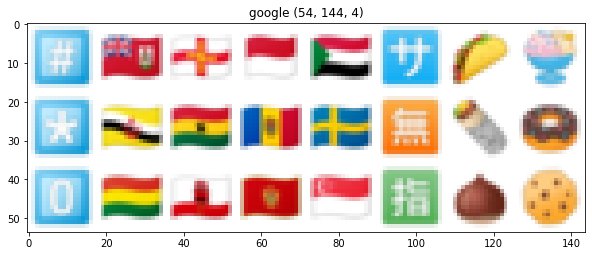

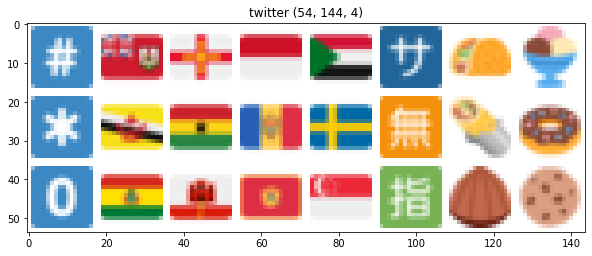

In [9]:
# Your answer here. Aim for 5-9 lines.
nb_rows = 3
nb_columns = 8
for vendor, sheet in sheets.items():
    plt.figure(figsize=(10,10))
    sheet_sliced = sheet[:EMOJI_SIZE*nb_rows+PAD*2*nb_rows, :(EMOJI_SIZE*nb_columns)+(PAD*2*nb_columns)]
    plt.imshow(sheet_sliced)
    plt.title(f'{vendor} {sheet_sliced.shape}')

**Implement *get_emoji_image*.** It should extract a 16x16 RGBA emoji image by its style index (0=*apple*, 1=*facebook*, 2=*google*, 3=*twitter*) and emoji index (as they appear in *emoji.json*). Internally, your function may refer to any global variables you have already defined (metadata, images, size, padding). Use the *sheet_x* and *sheet_y* fields of the metadata. Use slicing and avoid for-loops. <span style="color:#080;font-weight:bold">Briefly comment each line of your code.</span>

In [10]:

def get_emoji_image(style_index, emoji_index):
    """
    Given a vendor style index (apple=0,facebook=1,google=2,twitter=3)
    and an emoji index, returns the 16x16 RGBA image as a Numpy array
    with shape (16,16,4).
    """
    # Your implementation here. Aim for 5-8 lines (not including comments).
    
    #convert sheets dictionnary values into a list to index by style_index
    vendor_sheet = list(sheets.values())[style_index]
    
    #extract sheet_x and sheet_y from metadata which are the column and row index in the sheet
    col = metadata[emoji_index]["sheet_x"]
    row = metadata[emoji_index]["sheet_y"]
    
    #the index of the emoji
    i = row*(EMOJI_SIZE + 2*PAD) + PAD
    j = col*(EMOJI_SIZE + 2*PAD) + PAD
    
    return vendor_sheet[i:i+EMOJI_SIZE,j:j+EMOJI_SIZE]
          

**Implment *plot_emoji_styles*.** Implement the *plot_emoji_styles* function below, using your *get_emoji_image* function as a subroutine. Use *figsize* to control the size of your figure, use Matplotlib's *subplot* and *title* functions along with its **[suptitle](https://matplotlib.org/3.3.2/api/_as_gen/matplotlib.pyplot.suptitle.html)** to create titles that show the emoji index, the emoji short name, and the vendor title above each style, as shown below:

<img src="img/example-plot-emoji-styles.png" width=600/>

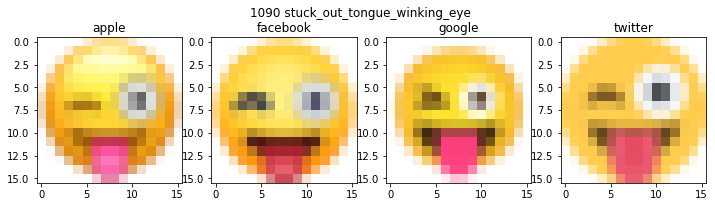

In [11]:
def plot_emoji_styles(emoji_index):
    """Plots all four vendor styles of the given emoji."""
    # Your implementation here. Aim for 6-8 lines.
    plt.figure(figsize = (12,3))
    plt.suptitle(f'{emoji_index} {metadata[emoji_index]["short_name"]}')  
    for i, k in enumerate(sheets):
        plt.subplot(1,4,i+1)
        plt.imshow(get_emoji_image(i,emoji_index))
        plt.title(k)
               
plot_emoji_styles(1090)

**Run your *plot_emoji_styles*** function to plot the '*laughing*' emoji from **Q1b**. Also plot two other emojis of your choosing. (Except poop. You're not allowed to plot the poop emoji. Don't you dare. No, no wait stop, have some self-respect, don't do it, noooo!)

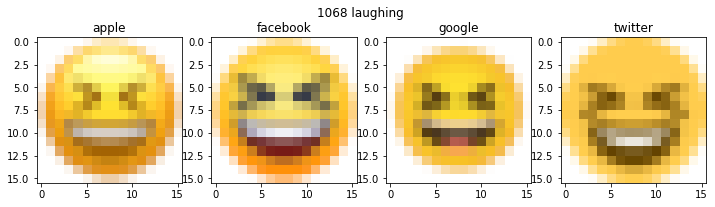

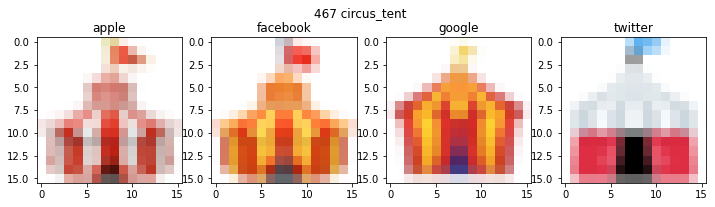

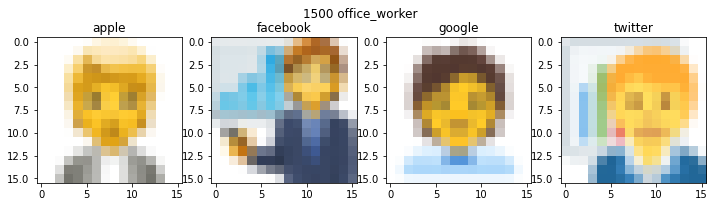

In [12]:
# Your code here. Aim for 2-3 lines.
plot_emoji_styles(index)
plot_emoji_styles(467)
plot_emoji_styles(1500)

<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>
<div style="border-bottom: 3px solid black"></div>

# Q2 &mdash; Build an emoji data set for machine learning [20 marks total]

This question is about converting your list of four raw image sheets into a data set suitable for training with scikit-learn. 

<div style="border-bottom: 1px solid black;"></div>

### *Q2a &mdash;  Build a set of inputs $\boldsymbol{X}$ from the sheet images [5 marks]*

**Write code** to build a Numpy array of inputs $\boldsymbol{X}$ having dtype *float32* and shape $(N,D)$ where $N$ is the total number of emoji images (number of emojis $\times$ number of vendors) and $D$ is the total number of pixels per emoji (height $\times$ width $\times$ channels). Each image should be converted from RGBA (4 channels) to RGB (3 channels) using the *rgba_to_rgb* function defined at the top of this lab. The first rows of $\boldsymbol{X}$ should all be apple emojis, followed by all facebook emojis, then all google emojis, and finally the last rows should be all twitter emojis. <span style="color:#080;font-weight:bold">Briefly comment each non-trivial line of your code.</span>

In [13]:
# Your answer here. Aim for 6-10 lines.
num_vendors = 4
num_emojis = 1810

X = np.empty((num_emojis*num_vendors, 16*16*3), dtype= np.float32)

for i in range(0,num_vendors):
    for j in range(0,num_emojis):
        #get each emoji individually and convert them to rgb
        emoji_image =  rgba_to_rgb(get_emoji_image(i, j))
        #append emoji to X and ravel() to get total number of pixels per emoji
        X[i*num_emojis+j] = emoji_image.ravel()

print(X.shape)

(7240, 768)


<div style="border-bottom: 1px solid black;"></div>

### *Q2b &mdash;  Build a set of targets $\boldsymbol{y}$ from the metadata [5 marks]*

Here you'll enumerate the distinct emoji categories, and then build a vector of integer targets $\boldsymbol{y}$.

**Write code** to get a list of distinct emoji categories, using the *category* field from the metadata; ensure that the list of categories is displayed when the code cell below is executed.

In [14]:
# Your answere here. Aim for 2-4 lines.
categories = []

for obj in metadata:
    if obj['category'] not in categories:
        categories.append(obj['category'])
        
print(categories)

['Symbols', 'Activities', 'Flags', 'Travel & Places', 'Food & Drink', 'Animals & Nature', 'People & Body', 'Objects', 'Skin Tones', 'Smileys & Emotion']


**Write code** to build a Numpy array of inputs $\boldsymbol{y}$ having dtype *int32* and where $y_i \in \{0, \ldots, M-1\}$ with $M$ being the number of distinct emoji categories. The order of items in $\boldsymbol{y}$ should match those of $\boldsymbol{X}$ from **Q2a**. You may use any approach you like, but potentially useful functions include the *list* object's **[index](https://docs.python.org/3/tutorial/datastructures.html)** function and Numpy's **[np.tile](https://numpy.org/doc/stable/reference/generated/numpy.tile.html)** function. <span style="color:#080;font-weight:bold">Briefly comment each non-trivial line of your code.</span>

In [15]:
# Your answer here. Aim for 3-5 lines.
y = np.empty((num_emojis,),dtype=np.int32)

#for one vendorsheet, add all target y categories in order
for i in range(0,num_emojis):
    category = metadata[i]['category']
    #using enumerate to index the categories and append them to y
    for j, cat in enumerate(categories):    
        if category == cat:
            y[i] = j

#using tile to reproduce for the remainding 3 vendor sheets            
y = np.tile(y,4)
print(y.shape)

(7240,)


**Write code** to demonstrate that, for each $i$ that corresponds to a '*laughing*' emoji (for apple, facebook, google, twitter), its $y_i$ label is set to be the index of the "Smileys & Emotion" category.

In [16]:
# Your answer here. Aim for 1-3 lines.
for i,x in enumerate(metadata):
    if 'laughing' in x['short_names']:
        print(y[i])
        print(y[i+num_emojis])
        print(y[i+num_emojis*2])
        print(y[i+num_emojis*3])

9
9
9
9


<div style="border-bottom: 1px solid black;"></div>

### *Q2c &mdash;  Split and preprocess the data [10 marks]*

**Write code** to randomly split $(\boldsymbol{X}, \boldsymbol{y})$ into three parts, with no overlap:
1. a *training* set $(\boldsymbol{X}_\text{trn}, \boldsymbol{y}_\text{trn})$, which you will use to directly train classifiers
2. a *validation* set $(\boldsymbol{X}_\text{val}, \boldsymbol{y}_\text{val})$, which you will use to estimate the best value for a hyperparameter
3. a *test* set $(\boldsymbol{X}_\text{tst}, \boldsymbol{y}_\text{tst})$, which you will use to evaluate final performance of the 'best' hyperparameters

The training data should comprise 60% of the full data set. The validation and testing data should each comprise 20% of the original data. Use the **[train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)** function and remember to set *random_state* so that your splits (and thereby your conclusions) are reproducible for TAs.

In [17]:
# Your code here. Aim for 2-3 lines.
X_train, X_tst, y_train, y_tst = sklearn.model_selection.train_test_split(X, y, test_size=0.20, random_state=0)
X_trn, X_val, y_trn, y_val = sklearn.model_selection.train_test_split(X_train, y_train, test_size=0.25, random_state=0)


**Write code** to normalize the features of $\boldsymbol{X}_\text{trn}$, $\boldsymbol{X}_\text{val}$, and $\boldsymbol{X}_\text{tst}$, using scikit-learn's **[StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)**. Be careful which subset of the data you use for estimating the *StandardScaler* object's *scale_* and *mean_* attributes.

In [18]:
# Your answer here. Aim for 4-5 lines.
X_trn_scaled = sklearn.preprocessing.StandardScaler().fit(X_trn).transform(X_trn)
X_val_scaled = sklearn.preprocessing.StandardScaler().fit(X_val).transform(X_val)
X_tst_scaled = sklearn.preprocessing.StandardScaler().fit(X_tst).transform(X_tst)

**Plot a scaled and unscaled emoji side-by-side.** Choose a row from $\boldsymbol{X}_\text{trn}$ and show how it appears as an RGB image with and without scaling. If Matplotlib complains that values are not in range [0,1], consider using **[np.clip](https://numpy.org/doc/stable/reference/generated/numpy.clip.html)**. Your plot should look like the example below, although the choice of emoji could differ.

<img src="img/example-scaled-emoji.png" width=250/>

*Hint:* You do not need to know which row in $\boldsymbol{X}_\text{trn}$ corresponds to which row in $\boldsymbol{X}$. Instead you can "undo" the scaling on whatever row you pick, using one of the methods provided by *StandardScaler*.

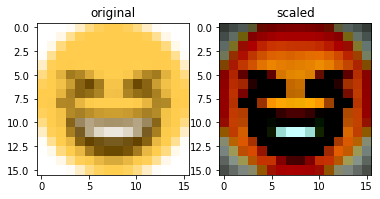

In [19]:
# Your answer here. Aim for 9-12 lines.

a = np.reshape(X_trn[100],(16,16,3))
b = np.reshape(X_trn_scaled[100],(16,16,3))
a = np.clip(a,0,1)
b = np.clip(b,0,1)
plt.figure()
plt.subplot(1,2,1)
plt.title("original")
plt.imshow(a)
plt.subplot(1,2,2)
plt.title("scaled")
plt.imshow(b);

<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>
<div style="border-bottom: 3px solid black"></div>

# Q3 &mdash; Train classifiers and identify good hyperparameters [20 marks total]

This question has several goals:
1. to help you visualize how hyperparameters affect training/validation/test performance.
2. to give you a sense for how long certain classifiers take to train or to make predictions.
3. to force you to try two useful Python features: (a) passing types as arguments, and (b) argument forwarding.

(However, please take the hyperparameter search lab as a better example of how to use scikit-learn for hyperparameter search; this assignment is focused on making things easy to plot and visualize, not on automating the search itself.)

<div style="border-bottom: 1px solid black;"></div>

### *Q3a &mdash;  Write a function to trains multiple estimators [5 marks]*

Throughout **Q3**, you will be training multiple estimators, each with a different hyperparameter setting.

**Implement the *train_estimators* utility function.** The idea of this function is to make it easy to train multiple versions of an estimator where a single hyperparameter (specified by *param_name*) takes on a different value (specified by *param_vals*) for each estimator. See the docstring below.

*Hint:* For details on how Python argument forwarding works (`**kwargs`), see [this Stack Overflow answer](https://stackoverflow.com/a/36908).

In [20]:
def train_estimators(X, y, estimator_type, param_name, param_vals, **kwargs):
    """
    Trains multiple instances of `estimator_type` on (X, y) by setting argument
    named `param_name` to each value in `param_vals`. Prints a message before
    training each instance. Returns the list of trained estimators.
    
    For example:
    
       >>> train_estimators(X, y, DecisionTreeClassifier, 'max_depth', [1, 5, 10],
                            splitter='random', random_state=0)
    
       Training DecisionTreeClassifier(max_depth=1, random_state=0, splitter='random')...
       Training DecisionTreeClassifier(max_depth=5, random_state=0, splitter='random')...
       Training DecisionTreeClassifier(max_depth=10, random_state=0, splitter='random')...

       [DecisionTreeClassifier(max_depth=1, random_state=0, splitter='random'),
        DecisionTreeClassifier(max_depth=5, random_state=0, splitter='random'),
        DecisionTreeClassifier(max_depth=10, random_state=0, splitter='random')] 
    """
    # Your implementation here. Aim for 5-10 lines.
    trained_estimators = []   
    for param_val in param_vals:
        kwargs[param_name] = param_val
        estimator = estimator_type(**kwargs).fit(X,y)
        print(f'Training {estimator}')
        trained_estimators.append(estimator)
    return trained_estimators
        

**Run the code cell below** to test your implementation of *train_estimators*. (Replace *X_trn* and *y_trn* with whatever you called your training set variables.)

In [21]:
tree_estimators = train_estimators(X_trn, y_trn, sklearn.tree.DecisionTreeClassifier,
                                   'max_depth', [1, 5, 10], splitter='random', random_state=0)
tree_estimators

Training DecisionTreeClassifier(max_depth=1, random_state=0, splitter='random')
Training DecisionTreeClassifier(max_depth=5, random_state=0, splitter='random')
Training DecisionTreeClassifier(max_depth=10, random_state=0, splitter='random')


[DecisionTreeClassifier(max_depth=1, random_state=0, splitter='random'),
 DecisionTreeClassifier(max_depth=5, random_state=0, splitter='random'),
 DecisionTreeClassifier(max_depth=10, random_state=0, splitter='random')]

<div style="border-bottom: 1px solid black;"></div>

### *Q3b &mdash;  Train multiples models, plot their accuracies, and identify good parameters [15 marks]*

**Implement the *score_estimators* utility function.** This will be handy for scoring a list of estimators on a particular data set, such as $(\boldsymbol{X}_\text{trn}, \boldsymbol{y}_\text{trn})$. Use the estimator's own *score* method.

In [22]:
def score_estimators(X, y, estimators):
    """Scores each estimator on (X, y), returning a list of scores."""
    # Your implementation here. Aim for 1-4 lines.
    scores=[]
    for e in estimators:
        scores.append(e.score(X,y))
    return scores

**Run the code cell below** to test your implementation. It should print three scores per dataset. Each score is a measure of classification accuracy. (Replace *X_trn* and *y_trn* etc with your data set variables.)

In [23]:
print("train:   ", score_estimators(X_trn, y_trn, tree_estimators))
print("validate:", score_estimators(X_val, y_val, tree_estimators))
print("test:    ", score_estimators(X_tst, y_tst, tree_estimators))

train:    [0.2999539594843462, 0.5105893186003683, 0.7453959484346224]
validate: [0.3294198895027624, 0.5220994475138122, 0.5552486187845304]
test:     [0.31077348066298344, 0.4937845303867403, 0.5511049723756906]


In [33]:
%%time

tree_estimators = train_estimators(X_trn, y_trn, sklearn.tree.DecisionTreeClassifier,'max_depth', [1, 5, 10, 20, 50, 100], splitter='random', random_state=0)
print("test:    ", score_estimators(X_tst, y_tst, tree_estimators))

Training DecisionTreeClassifier(max_depth=1, random_state=0, splitter='random')
Training DecisionTreeClassifier(max_depth=5, random_state=0, splitter='random')
Training DecisionTreeClassifier(max_depth=10, random_state=0, splitter='random')
Training DecisionTreeClassifier(max_depth=20, random_state=0, splitter='random')
Training DecisionTreeClassifier(max_depth=50, random_state=0, splitter='random')
Training DecisionTreeClassifier(max_depth=100, random_state=0, splitter='random')
test:     [0.31077348066298344, 0.4937845303867403, 0.5511049723756906, 0.5379834254143646, 0.5490331491712708, 0.5490331491712708]
CPU times: total: 1.92 s
Wall time: 2.03 s


In [26]:
def plot_estimator_scores(estimators, param_name, param_vals):
    """
    Plots the training, validation, and testing scores of a list of estimators,
    where `param_name` and `param_vals` are the same as for `train_estimators`.
    The estimator with best validation score will be highlighted with an 'x'.
    """
    # Your implementation here. Use as many lines as you need.
    trn_scores = score_estimators(X_trn, y_trn, estimators)
    val_scores = score_estimators(X_val, y_val, estimators)
    tst_scores = score_estimators(X_tst, y_tst, estimators)
    best_index = np.argmax(val_scores)
    print(best_index)
    
    plt.plot(np.arange(6),trn_scores,'o-g',label= 'train')
    plt.plot(np.arange(6),val_scores, 'o-r',label='validate')
    plt.plot(np.arange(6),tst_scores,':k',label='test')
    plt.scatter(best_index, val_scores[best_index], marker='x',s=200, color='r')
        
    plt.xticks(np.arange(6),param_vals) 
    plt.yticks(np.arange(0,1.2,0.2))
    plt.title(f'{estimators[0].__class__.__name__} score vs {param_name}')
    plt.xlabel(param_name)
    plt.ylabel("score")
    plt.text(.9,.3,"train = %.3f" %trn_scores[np.argmax(trn_scores)],color='g',transform=plt.gca().transAxes, horizontalAlignment='right')
    plt.text(.9,.2,"validate = %.3f" %val_scores[best_index], color='r', transform=plt.gca().transAxes, horizontalAlignment='right')
    plt.text(.9,.1,"test = %.3f" %tst_scores[np.argmax(tst_scores)], color='k', transform=plt.gca().transAxes, horizontalAlignment='right')
    plt.legend()
    
        

**Plot the *DecisionTreeClassifier* scores** by calling your *plot_estimator_scores* function. Your plot should look like the example plot.

**Train multiple *RandomForestClassifiers*** such that *train_estimators* produces the following output:

    Training RandomForestClassifier(max_depth=1, random_state=0)...
    Training RandomForestClassifier(max_depth=5, random_state=0)...
    Training RandomForestClassifier(max_depth=10, random_state=0)...
    Training RandomForestClassifier(max_depth=20, random_state=0)...
    Training RandomForestClassifier(max_depth=50, random_state=0)...
    Training RandomForestClassifier(max_depth=100, random_state=0)...

In [36]:
%%time
# Your code here. Aim for 1-2 lines.
rf_estimators = train_estimators(X_trn, y_trn, sklearn.ensemble.RandomForestClassifier,
                                   'max_depth', [50], random_state=0)

print("test:    ", score_estimators(X_tst, y_tst, rf_estimators))

Training RandomForestClassifier(max_depth=50, random_state=0)
test:     [0.7223756906077348]
CPU times: total: 5.16 s
Wall time: 5.36 s


**Plot the *LogisticRegression* scores**, again by calling your *plot_estimator_scores* function.

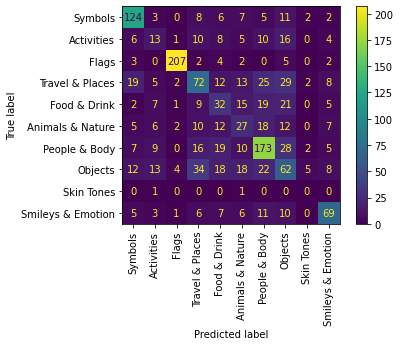

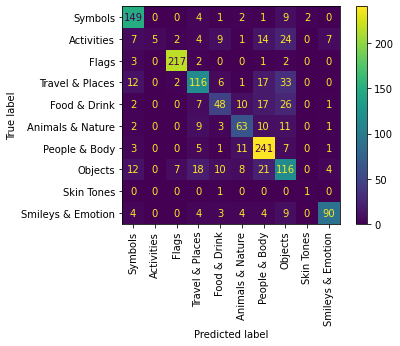

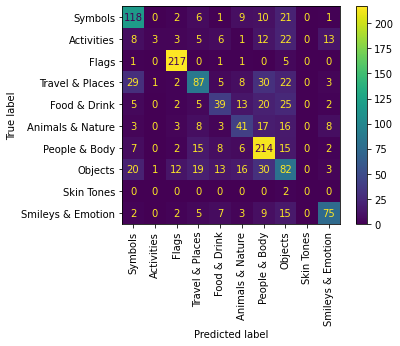

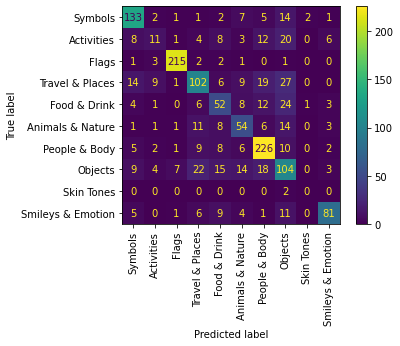

In [ ]:
# Your answer here. Aim for 7-12 lines.
sklearn.metrics.plot_confusion_matrix(tree_estimators[3],X_tst,y_tst,display_labels=categories, xticks_rotation='vertical')
sklearn.metrics.plot_confusion_matrix(rf_estimators[4],X_tst,y_tst,display_labels=categories, xticks_rotation='vertical')
sklearn.metrics.plot_confusion_matrix(lg_estimators[4],X_tst,y_tst,display_labels=categories, xticks_rotation='vertical')
sklearn.metrics.plot_confusion_matrix(svm_estimators[4],X_tst,y_tst,display_labels=categories, xticks_rotation='vertical')

<div style="border-bottom: 1px solid black;"></div>

### *Q5a &mdash;  Visualize the feature importances of a RandomForestClassifier [5 marks]*

**Implement *plot_random_forest_importances*** below. This function should plot the *feature_importances_* attribute of a *RandomForestClassifier* (see scikit-learn docs). For the random forests you trained, there are $16 \times 16 \times 3$ features, so to make visualization easy the feature importances should be organized into three separate side-by-side heatmaps: one for each RGB colour channel. When plotting a heatmap, use *cmap*='cool' to choose the colour map. For example, plotting the feature importances of a random forest with *max_depth*=1 should look something like this:

<img src="img/example-random-forest-feature-importances.png" width="350"/>

In [ ]:
def plot_random_forest_importances(estimator):
    """
    Plots the feature importances of the given RandomForestClassifier,
    arranged as three separate 16x16 heatmaps for (red, green, blue).
    """
    # Your implementation here. Aim for 7-10 lines.
    s = estimator.feature_importances_.reshape(16,16,3)
    for j,title in enumerate('RGB'):
        plt.subplot(1,3,j+1)
        plt.imshow(s[:,:,j],cmap='cool')
        plt.title(title)
        plt.axis('off')